## IMPORTS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from metrics.dataquality import calculate_data_quality_metrics
from metrics.dataquality import calculate_phone_number_metrics
from metrics.dataquality import calculate_email_metrics
from metrics.dataquality import calculate_average_metrics

from metrics.overallscore import calculate_overall_score
from metrics.overallscore import calculate_overall_score_mom

from metrics.feature_calculations import calculate_unique_meter_count
from metrics.feature_calculations import calculate_metrics_by_month

from metrics.datacollectorscore import calculate_quality_score_by_collector

## READING DATA

In [2]:
# data = pd.read_csv("data/ecg/customers_sep_nov.csv")
data = pd.read_csv("data/ecg/customers_v2_jan_2024.csv")
data_v2 = pd.read_csv("data/ecg/customers_v2_.csv")

In [3]:
caims1 = pd.read_csv("data/ecg/caims1.csv")
caims2 = pd.read_csv("data/ecg/caims2.csv")
caims3 = pd.read_csv("data/ecg/caims3.csv")
caims4 = pd.read_csv("data/ecg/caims4.csv")
caims5 = pd.read_csv("data/ecg/caims5.csv", dtype={'ac_no': str}, low_memory=False)

In [4]:
caims_data = pd.concat(
	[caims1,
	caims2,
	caims3,
	caims4,
	caims5]
)

In [5]:
column_mapping = {
    'slrn': 'SLRN',
    'ac_no': 'Account Number',
    'meter_number': 'Meter Number',
    'meter_status': 'Meter Status',
    'meter_slrn': 'Meter SLRN',
    'phone_number': 'Phone Number',
    'email': 'Email',
    'date': 'Date',
    'first_captured_username': 'First Captured Username',
    'updated_username': 'Updated Username'
}
data_x = caims_data.copy()
data_x.rename(columns=column_mapping, inplace=True)

In [9]:
filtered_data_ecg = data_x[data_x['SLRN'].fillna('').str.startswith('ECG')]

In [10]:
df = filtered_data_ecg.copy()

## METRICS

In [11]:
# List to store metrics for each key field
metrics_list = []

# Calculate metrics for each key field
key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN', 'Phone Number', 'Email']

for field_name in key_fields:
    if field_name in df.columns:
        if field_name in ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN']:
            metrics = calculate_data_quality_metrics(df, field_name, 'ECGBD', 12, 'ECGCR', 11)
        elif field_name == 'Phone Number':
            metrics = calculate_phone_number_metrics(df, field_name, 'ECGBD', corresponding_meter_field='Meter Number')
        elif field_name == 'Email':
            metrics = calculate_email_metrics(df, field_name, corresponding_meter_field='Meter Number')
        
        metrics_list.append(metrics)

# Calculate average completeness, validity, and integrity
average_completeness = calculate_average_metrics(metrics_list, 'Completeness')
average_validity = calculate_average_metrics(metrics_list, 'Validity')
average_integrity = calculate_average_metrics(metrics_list, 'Integrity')

# Calculate overall score using the overall_score function
overall_score = calculate_overall_score(average_completeness, average_validity, average_integrity)

total_caims_data = df['Meter Number'].nunique()
print(f'\nSample Data: {total_caims_data:,}')

# Display the results
print("\nQuality Metrics for Each Field:")
for field_name in key_fields:
    if field_name in df.columns:
        print(f"\nMetrics for {field_name}:")
        print(f"Completeness: {metrics_list[key_fields.index(field_name)]['Completeness']:.2f}%")
        print(f"Validity: {metrics_list[key_fields.index(field_name)]['Validity']:.2f}%")
        print(f"Integrity: {metrics_list[key_fields.index(field_name)]['Integrity']:.2f}%")
        
        # Calculate and print the overall score for each field
        field_overall_score = calculate_overall_score(
            metrics_list[key_fields.index(field_name)]['Completeness'],
            metrics_list[key_fields.index(field_name)]['Validity'],
            metrics_list[key_fields.index(field_name)]['Integrity']
        )
        print(f"Overall Score: {field_overall_score:.2f}")

print("\nQuality Metrics - Average and Overall Score:")
print(f"Average Completeness: {average_completeness:.2f}%")
print(f"Average Validity: {average_validity:.2f}%")
print(f"Average Integrity: {average_integrity:.2f}%")
print(f"Overall Score: {overall_score:.2f}")



Sample Data: 1,242,186

Quality Metrics for Each Field:

Metrics for SLRN:
Completeness: 100.00%
Validity: 99.91%
Integrity: 99.94%
Overall Score: 100.00

Metrics for Account Number:
Completeness: 72.55%
Validity: 71.85%
Integrity: 72.25%
Overall Score: 72.00

Metrics for Meter Number:
Completeness: 99.65%
Validity: 96.82%
Integrity: 71.63%
Overall Score: 92.80

Metrics for Meter SLRN:
Completeness: 99.54%
Validity: 99.40%
Integrity: 99.52%
Overall Score: 100.00

Metrics for Phone Number:
Completeness: 81.93%
Validity: 68.48%
Integrity: 61.54%
Overall Score: 72.40

Metrics for Email:
Completeness: 36.28%
Validity: 12.81%
Integrity: 1.08%
Overall Score: 19.60

Quality Metrics - Average and Overall Score:
Average Completeness: 81.66%
Average Validity: 74.88%
Average Integrity: 67.66%
Overall Score: 76.00


In [12]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year Month'] = df['Date'].dt.to_period('M')
df['date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
df["date"] = df.date.astype(str)
df["year_month"] = df.date.str[0:7]
df["year_month"] = df.year_month.str.replace('-', '')
df["year_month"] = df.year_month.apply(lambda x: int(x) if str(x).isdigit() else 0)

In [13]:
# Compute unique meter count
unique_meter_count_df = calculate_unique_meter_count(df, 'Year Month', 'Meter Number')


# Calculate overall data quality score on a monthly basis and link it back to the DataFrame
mom_overall_score = calculate_overall_score_mom(df)
mom_overall_score_fil = mom_overall_score[mom_overall_score['year_month'] >= 202302]
mom_overall_score_fil = mom_overall_score_fil[['Year Month', 'Overall Score', 'year_month']]
mom_overall_score_fil = mom_overall_score_fil.sort_values(by='year_month', ascending=True)
mom_overall_score_fil = mom_overall_score_fil.drop_duplicates(subset=['Year Month'])

mom_overall_score_fil = pd.merge(mom_overall_score_fil, unique_meter_count_df, on='Year Month', how='left')

## MOM CHART

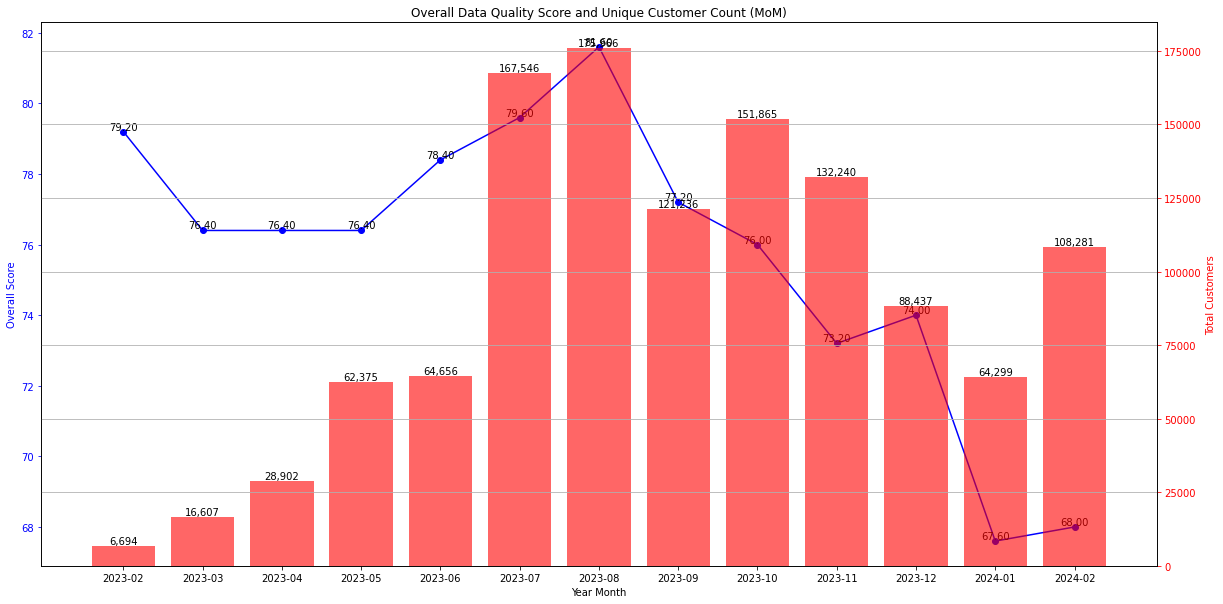

In [14]:
# Plot overall data quality score on a MoM basis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the overall score on the primary y-axis
ax1.plot(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Overall Score'].round(2), marker='o', linestyle='-', color='b', label='Overall Score')
ax1.set_xlabel('Year Month')
ax1.set_ylabel('Overall Score', color='b')
ax1.tick_params('y', colors='b')

# Text annotations
for i, txt in enumerate(mom_overall_score_fil['Overall Score'].round(2)):
    ax1.text(mom_overall_score_fil['Year Month'].astype(str).iloc[i], txt, f'{txt:.2f}', ha='center', va='bottom')

# Secondary y-axis for the count of unique meter numbers
ax2 = ax1.twinx()
bars = ax2.bar(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Unique Meter Count'], alpha=0.6, color='red', label='Unique Meter Count')
ax2.set_ylabel('Total Customers', color='r')
ax2.tick_params('y', colors='r')

# Add labels on the bar chart with MoM figures
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', va='bottom', ha='center')

# Show the plot
plt.title('Overall Data Quality Score and Unique Customer Count (MoM)')
plt.grid(True)
plt.show()


In [ ]:
mom_overall_score_fil[['Year Month', 'Overall Score']].to_csv('data/exports/mom_overall_score_dec_2023.csv', index=False)

### CALCULATE METRICS BY MONTH

In [15]:
key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN', 'Phone Number', 'Email']

mom_data_quality_metrics = calculate_metrics_by_month(
    df, 
    key_fields, 
    bd_slrn='ECGBD', 
    bdslrn_len=12, 
    meter_slrn='ECGCR', 
    mslrn_len=11
)


In [16]:
mom_data_quality_metrics

,Year Month,Key fields,Completeness,Validity,Integrity,Average Completeness,Average Validity,Average Integrity,Overall Score,Unique Meter Count
113,2024-02,Email,0.568156,0.566133,0.565122,73.643581,63.726875,64.343852,68.0,108281
112,2024-02,Phone Number,57.978457,16.184859,2.220284,73.643581,63.726875,64.343852,68.0,108281
111,2024-02,Meter SLRN,99.964348,99.963589,99.963589,73.643581,63.726875,64.343852,68.0,108281
110,2024-02,Meter Number,99.973451,82.269590,99.984070,73.643581,63.726875,64.343852,68.0,108281
109,2024-02,Account Number,83.377077,83.377077,83.367974,73.643581,63.726875,64.343852,68.0,108281
...,...,...,...,...,...,...,...,...,...,...
19,2022-08,Account Number,93.206209,92.449214,91.730548,91.490993,83.255877,77.845918,86.0,10224
20,2022-08,Meter Number,98.275201,98.169797,99.808356,91.490993,83.255877,77.845918,86.0,10224
21,2022-08,Meter SLRN,97.738597,97.249904,97.738597,91.490993,83.255877,77.845918,86.0,10224
22,2022-08,Phone Number,97.010349,89.665581,76.399003,91.490993,83.255877,77.845918,86.0,10224


In [15]:
mom_data_quality_metrics.to_csv('data/exports/mom_metrics_feb.csv', index=False)

In [ ]:
jan_df = df[df['Date'] > '2023-12-31']
dec_df = df[df['year_month'] == 202312]

In [ ]:
dec_df.to_csv('dec_df.csv', index=False)

## QUALITY SCORE BY DATA COLLECTOR

In [ ]:
df_x = df[df['year_month'] >= 202311]

field_metrics = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN', 'Phone Number', 'Email']

collector_scores = calculate_quality_score_by_collector(df_x, field_metrics)

collector_scores


,Average Completeness,Average Validity,Average Integrity,Overall Average
RolandA,40.00%,40.00%,40.00%,40.00%
AsieduS,40.00%,40.00%,40.00%,40.00%
CharlesA,37.78%,37.78%,36.67%,37.41%
Abugaemmanuel,36.67%,36.67%,36.67%,36.67%
ErnestKabu,36.88%,36.60%,36.28%,36.59%
...,...,...,...,...
StephanieOwusu,24.71%,24.00%,21.18%,23.29%
EnochOsei,24.03%,23.53%,21.55%,23.04%
JenniferNdinga,23.05%,22.92%,22.79%,22.92%
PeterBernasko,21.25%,21.17%,20.83%,21.08%


In [ ]:
collector_scores.to_csv('data/exports/collectors_score_dec_2023.csv', index=True)

In [32]:
import pandas as pd
import re

def preprocess_meter_number(meter_number):
    """
    Preprocess a meter number to remove scientific notation.
    """
    # Convert meter number to string
    meter_number = str(meter_number)
    
    # Remove scientific notation if present
    if 'e' in meter_number.lower():
        try:
            meter_number = '{:.0f}'.format(float(meter_number))
        except ValueError:
            # If conversion to float fails, return original value
            return meter_number
    
    return meter_number


def is_valid_meter_number(meter_number):
    """
    Check if a meter number is valid.
    """
    # Define conditions for meter number validity
    valid_format = bool(re.match(r'^[0-9a-zA-Z]{5,14}$', meter_number))
    has_alpha_chars = sum(c.isalpha() for c in meter_number) <= 3
    
    # Check if all conditions are met
    return valid_format and has_alpha_chars

def preprocess_phone_number(phone_number):
    """
    Preprocess a phone number to remove non-numeric characters.
    """
    # Convert phone number to string
    phone_number = str(phone_number)
    
    # Remove non-numeric characters
    phone_number = re.sub(r'\D', '', phone_number)
    
    return phone_number


def is_valid_phone_number(phone_number):
    """
    Check if a phone number is valid.
    Valid phone numbers must start with '233' or '+233' and have a total length of 12.
    """
    # Define regular expression pattern for valid phone numbers
    pattern = r'^(\+?233)?0*\d{6,9}$'
    
    # Check if phone number matches the pattern
    return bool(re.match(pattern, phone_number))



def pn_has_integrity(phone_number, meter_number):
    """
    Check if a phone number has integrity.
    """
    pattern = r'^(\+?233)?0*\d{6,9}$'
    
    # Check if phone number matches the pattern
    
    has_meter_number = not pd.isnull(meter_number)
    
    # Check if all conditions are met
    return bool(re.match(pattern, phone_number)) and has_meter_number


def calculate_validity(df, field_name, slrn_prefix='', slrn_length=0, meter_prefix='', meter_length=0, corresponding_meter_field=''):
    if field_name == 'SLRN':
        return (df[field_name].apply(lambda x: str(x).startswith(slrn_prefix) and len(str(x)) == slrn_length)).map({True: 'Valid', False: 'Not Valid'})
    elif field_name == 'Meter SLRN':
        return (df[field_name].apply(lambda x: str(x).startswith(meter_prefix) and len(str(x)) >= meter_length)).map({True: 'Valid', False: 'Not Valid'})
    elif field_name == 'Account Number':
        return (df[field_name].apply(lambda x: str(x).isnumeric())).map({True: 'Valid', False: 'Not Valid'})
    elif field_name == 'Meter Number':
        # Preprocess meter numbers
        df['Processed Meter Number'] = df[field_name].apply(preprocess_meter_number)
        
        # Apply the validity check function to the preprocessed meter numbers
        df['Meter Number Validity'] = df['Processed Meter Number'].apply(is_valid_meter_number)
        
        # Map the boolean results to strings ('Valid' or 'Not Valid')
        return df['Meter Number Validity'].map({True: 'Valid', False: 'Not Valid'})
    elif field_name == 'Phone Number':        
        # Preprocess phone numbers
        df['Processed Phone Number'] = df[field_name].apply(preprocess_phone_number)
        
        # Apply the validity check function to the preprocessed phone numbers
        df['Phone Number Validity'] = df['Processed Phone Number'].apply(is_valid_phone_number)
        
        # Return 'Valid' if all conditions are met, otherwise 'Not Valid'
        return df['Phone Number Validity'].map({True: 'Valid', False: 'Not Valid'})
    elif field_name == 'Email':
        valid_format = df[field_name].apply(lambda x: re.match(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', str(x)) is not None)
        has_valid_characters = df[field_name].apply(lambda x: re.match(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', str(x)) is not None)
        has_no_placeholders = df[field_name].apply(lambda x: not pd.isnull(x) and str(x).strip() != '')
        # Return 'Valid' if all conditions are met, otherwise 'Not Valid'
        return ((valid_format & has_valid_characters & has_no_placeholders).map({True: 'Valid', False: 'Not Valid'}))
    else:
        return None

def calculate_integrity(df, field_name, corresponding_meter_field=''):
    if field_name == 'SLRN':
        return ((df['SLRN'].notnull()) & (df[corresponding_meter_field].notnull() & (df[corresponding_meter_field].str.len() > 5)) | df['Account Number'].notnull()).map({True: 'Has Integrity', False: 'No Integrity'})
    elif field_name == 'Meter SLRN':
        return ((df['Meter SLRN'].str.len() > 10) & (df['SLRN'].notnull()) & (df['Meter Number'].notnull())).map({True: 'Has Integrity', False: 'No Integrity'})
    elif field_name == 'Meter Number':
        # Preprocess meter numbers
        df['Processed Meter Number'] = df[field_name].apply(preprocess_meter_number)
        
        # Apply the validity check function to the preprocessed meter numbers
        df['Meter Number Validity'] = df['Processed Meter Number'].apply(is_valid_meter_number)
        
        # Check integrity based on conditions
        has_integrity = (
            (df['Processed Meter Number'].notnull()) &
            (df['Processed Meter Number'].str.len() >= 5) &
            (df['Meter Status'] == 'Metered') &
            (df['SLRN'].notnull()) &
            (df['Meter Number Validity'])
        )
        # Map True/False to 'Has Integrity'/'No Integrity'
        return has_integrity.map({True: 'Has Integrity', False: 'No Integrity'})
    elif field_name == 'Email':
        consistent_formats = df[field_name].apply(lambda x: re.match(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', str(x)) is not None)
        valid_characters = df[field_name].apply(lambda x: re.match(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', str(x)) is not None)
        no_placeholders = df[field_name].apply(lambda x: not pd.isnull(x) and str(x).strip() != '')
        # Check integrity based on conditions
        return ((consistent_formats) & (valid_characters) & (no_placeholders) & (df[corresponding_meter_field].notnull())).map({True: 'Has Integrity', False: 'No Integrity'})
    elif field_name == 'Phone Number':        
        # Preprocess phone numbers
        df['Processed Phone Number'] = df[field_name].apply(preprocess_phone_number)
        
        # Apply the integrity check function to the preprocessed phone numbers and corresponding meter numbers
        df['Phone Number Integrity'] = df.apply(lambda row: pn_has_integrity(row['Processed Phone Number'], row['Meter Number']), axis=1)
        
        # Return 'Has Integrity' if all conditions are met and there's a corresponding meter number, otherwise 'No Integrity'
        return df['Phone Number Integrity'].map({True: 'Has Integrity', False: 'No Integrity'})
    else:
        return None


In [33]:
# Define the fields of interest
fields_of_interest = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN', 'Phone Number', 'Email']

# Initialize a dictionary to store the results
results = {}

# Iterate through each field of interest
for field in fields_of_interest:
    # Calculate validity and integrity for the current field
    validity = calculate_validity(df, field, slrn_prefix='ECGBD', slrn_length=12, meter_prefix='ECGCR', meter_length=11)
    integrity = calculate_integrity(df, field, corresponding_meter_field='Meter Number')
    
    # Add validity and integrity to the results dictionary
    results[f"{field}"] = df[field]
    results[f"{field} Validity"] = validity
    results[f"{field} Integrity"] = integrity

results['Date'] = df['Date']

result_df = pd.DataFrame(results)

In [34]:
february_2024_data = result_df[(result_df['Date'].dt.year == 2024) & (result_df['Date'].dt.month == 2)]

# Export the filtered data to a CSV file
february_2024_data.to_csv('data/exports/february_2024_data_updated_2.csv', index=False)

In [ ]:
import pandas as pd
import re

def calculate_validity(df, field_name, slrn_prefix='', slrn_length=0, meter_prefix='', meter_length=0, corresponding_meter_field=''):
    if field_name == 'SLRN':
        return (df[field_name].apply(lambda x: str(x).startswith(slrn_prefix) and len(str(x)) == slrn_length)).map({True: 'Valid', False: 'Not Valid'})
    elif field_name == 'Meter SLRN':
        return (df[field_name].apply(lambda x: str(x).startswith(meter_prefix) and len(str(x)) >= meter_length)).map({True: 'Valid', False: 'Not Valid'})
    elif field_name == 'Account Number':
        return (df[field_name].apply(lambda x: str(x).isnumeric())).map({True: 'Valid', False: 'Not Valid'})
    elif field_name == 'Meter Number':
        return (df[field_name].apply(lambda x: bool(re.match(r'^[0-9a-zA-Z]{5,14}$', str(x))) and sum(c.isalpha() for c in str(x)) <= 3)).map({True: 'Valid', False: 'Not Valid'})
    elif field_name == 'Phone Number':
        valid_format = df[field_name].apply(lambda x: re.match(r'^(\+?233)?0*\d{6,9}$', str(x)) is not None)
        # has_valid_characters = df[field_name].apply(lambda x: re.match(r'^[\d\+]+$', str(x)) is not None)
        # has_special_characters = df[field_name].apply(lambda x: re.match(r'^[\d\+\s]+$', str(x)) is not None)
        # has_no_placeholders = df[field_name].apply(lambda x: not pd.isnull(x) and str(x).strip() != '')
        # Return 'Valid' if all conditions are met, otherwise 'Not Valid'
        return ((valid_format).map({True: 'Valid', False: 'Not Valid'}))
    elif field_name == 'Email':
        valid_format = df[field_name].apply(lambda x: re.match(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', str(x)) is not None)
        has_valid_characters = df[field_name].apply(lambda x: re.match(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', str(x)) is not None)
        has_no_placeholders = df[field_name].apply(lambda x: not pd.isnull(x) and str(x).strip() != '')
        # Return 'Valid' if all conditions are met, otherwise 'Not Valid'
        return ((valid_format & has_valid_characters & has_no_placeholders).map({True: 'Valid', False: 'Not Valid'}))
    else:
        return None

def calculate_integrity(df, field_name, corresponding_meter_field=''):
    if field_name == 'SLRN':
        return ((df['SLRN'].notnull()) & (df[corresponding_meter_field].notnull() & (df[corresponding_meter_field].str.len() > 5)) | df['Account Number'].notnull()).map({True: 'Has Integrity', False: 'No Integrity'})
    elif field_name == 'Meter SLRN':
        return ((df['Meter SLRN'].str.len() > 10) & (df['SLRN'].notnull()) & (df['Meter Number'].notnull())).map({True: 'Has Integrity', False: 'No Integrity'})
    elif field_name == 'Meter Number':
        return (((df['Meter Number'].notnull()) & (df['Meter Number'].str.len() >= 5) & (df['Meter Status'] == 'Metered')) | ((df['Meter Number'].isnull()) & (df['Meter Status'] == 'Unmetered'))).map({True: 'Has Integrity', False: 'No Integrity'})
    elif field_name == 'Email':
        consistent_formats = df[field_name].apply(lambda x: re.match(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', str(x)) is not None)
        valid_characters = df[field_name].apply(lambda x: re.match(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', str(x)) is not None)
        no_placeholders = df[field_name].apply(lambda x: not pd.isnull(x) and str(x).strip() != '')
        # Check integrity based on conditions
        return ((consistent_formats) & (valid_characters) & (no_placeholders) & (df[corresponding_meter_field].notnull())).map({True: 'Has Integrity', False: 'No Integrity'})
    elif field_name == 'Phone Number':
        consistent_formats = df[field_name].apply(lambda x: re.match(r'^(\+?\d{9,12})?$', str(x)) is not None)
        valid_characters = df[field_name].apply(lambda x: re.match(r'^[\d\+]+$', str(x)) is not None)
        special_characters = df[field_name].apply(lambda x: re.match(r'^[\d\+\s]+$', str(x)) is not None)
        no_placeholders = df[field_name].apply(lambda x: not pd.isnull(x) and str(x).strip() != '')
        # Check integrity based on conditions
        return ((consistent_formats) & (valid_characters) & (special_characters) & (no_placeholders) & (df[corresponding_meter_field].notnull())).map({True: 'Has Integrity', False: 'No Integrity'})
    else:
        return None
